# Hands-on Day 4

## You'll learn

### ML methods

- Deep NN with BigDL

In [1]:
# initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1337)  # for reproducibility

from custom_functions import *

In [2]:
num_workers = 5  # Do not use more than 7!
spark = %sc_bigDL $num_workers

from pyspark.sql import SparkSession

spark_session = SparkSession(spark)

# check if spark is there
spark
# spark._conf.getAll()

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 126, in run
    self.onrecv(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 143, in onrecv
    sendToFrontEnd({
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 223, in sendToFrontEnd
    monitor.send(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 57, in send
    self.comm.send(msg)
AttributeError: 'ScalaMonitor' object has no attribute 'comm'


<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-marchisi01>

In [3]:
# init bigDL context

from bigdl.dllib.nncontext import *

sc = init_nncontext()

/opt/conda/lib/python3.9/site-packages/bigdl/dllib/utils/engine.py:45: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark, and pyspark is found in: /opt/conda/lib/python3.9/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


## Read in input data

In [4]:
# inputFile = "file:///home/jovyan/Higgs100k.parquet"
inputFile = "file:///home/jovyan/Higgs1M.parquet"
# inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print("There are " + str(total_events) + " events")

CPU times: user 2.77 ms, sys: 955 µs, total: 3.72 ms
Wall time: 3.73 s
There are 999999 events


In [5]:
# split the dataset for training and test
train, test = df.randomSplit([0.8, 0.2])

print("Events for training {}".format(train.count()))
print("Events for validation {}".format(test.count()))


Events for training 800214
Events for validation 199785


In [6]:
# create input feature vector
feature = train.columns
feature.remove("label")

from pyspark.ml.feature import VectorAssembler

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol="features")


In [7]:
train = assembler.transform(train)
test = assembler.transform(test)

In [8]:
# In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(train.rdd.getNumPartitions()))
print("Partitioner: {}".format(train.rdd.partitioner))

Number of partitions: 5
Partitioner: None


## Exercise: create the model

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [9]:
# Create keras-like model:
# Only need to change package name from tensorflow.keras to bigdl.dllib.keras
# no callbacks in bigDL

from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.utils.common import JTensor

from bigdl.dllib.keras.optimizers import Adam
from bigdl.dllib.keras.layers.core import Dense, Activation, Dropout

In [10]:
# create the model
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(28,)))
model.add(Dense(1, activation="sigmoid"))
opt = Adam()

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasAdam
creating: createDefault


In [11]:
# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


In [12]:
# Set of hyperparameters
numEpochs = 10

# The batch used by BigDL must be a multiple of numExecutors * executorCores because data will be equally distributed inside each executor
# scale up or down according to size of input dataset
# workerBatch = 140  # for 100k dataset
workerBatch = 700  # for 1M dataset
numExecutors = int(sc._conf.get("spark.executor.instances"))
executorCores = int(sc._conf.get("spark.executor.cores"))

BigDLbatch = workerBatch * numExecutors * executorCores

print(str(BigDLbatch))

3500


In [13]:
# Create SparkML compatible estimator for deep learning training
from bigdl.dllib.optim.optimizer import (
    EveryEpoch,
    Loss,
    TrainSummary,
    ValidationSummary,
)
from bigdl.dllib.nnframes import *
from bigdl.dllib.keras.objectives import BinaryCrossEntropy

estimator = (
    NNEstimator(model, BinaryCrossEntropy())
    .setOptimMethod(Adam())
    .setBatchSize(BigDLbatch)
    .setMaxEpoch(numEpochs)
    .setFeaturesCol("features")
    .setLabelCol("label")
    .setValidation(
        trigger=EveryEpoch(),
        val_df=test,
        val_method=[Loss(BinaryCrossEntropy())],
        batch_size=BigDLbatch,
    )
)

creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createEveryEpoch
creating: createZooKerasBinaryCrossEntropy
creating: createLoss


## Create directory for logs

In [14]:
appName = "Classifier"
logDir = "/home/jovyan/bigDL"

# Check if there is already an application with the same name and remove it, otherwise logs will be appended to that app
import os

try:
    os.system("rm -rf " + logDir + "/" + appName)
except:
    pass

print("Saving logs to {}".format(logDir + "/" + appName))

trainSummary = TrainSummary(log_dir=logDir, app_name=appName)
estimator.setTrainSummary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir, app_name=appName)
estimator.setValidationSummary(valSummary)

Saving logs to /home/jovyan/bigDL/Classifier
creating: createTrainSummary
creating: createValidationSummary


NNEstimator_018e4523e49c

## Train model

In [15]:
# keep spark UI close!!!
# %time trained_model = estimator.fit(train)
import time

start_train = time.time()
trained_model = estimator.fit(train)
train_time = time.time() - start_train
print(f"Training time: {train_time} seconds")

creating: createToTuple
creating: createChainedPreprocessing
Training time: 220.49281454086304 seconds


In [16]:
# Predict with trained NNModel using pipeline transform API
predDF = trained_model.transform(test)
# predDF.printSchema()

y_pred = np.asarray(predDF.select("prediction").collect())
y_true = np.asarray(test.select("label").collect())

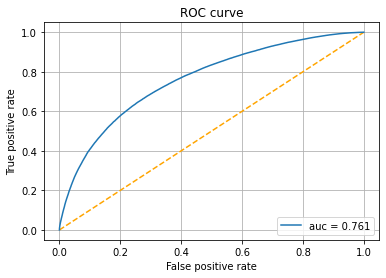

In [17]:
drawROC2(y_true[:, 0], y_pred[:, 0])

In [18]:
# create dataframe in same format as MLlib
from pyspark.sql import functions as f

# rename prediction to probability (predictions are binary, 0-1)
newDF = predDF.withColumn("probability", f.col("prediction"))
# overwrite prediction with binary values
result = newDF.withColumn(
    "prediction", f.when(f.col("probability")[0] > 0.5, 1.0).otherwise(0.0)
)
result.select(["probability", "prediction", "label"]).show()

# Calculate test accuracy
correct = result.filter(result.prediction == result.label).count()
total = result.count()
accuracy = correct / total
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Correct predictions: {correct} / {total}")

+--------------+----------+-----+
|   probability|prediction|label|
+--------------+----------+-----+
| [0.010258677]|       0.0|  0.0|
|   [0.4724305]|       0.0|  0.0|
|   [0.4965274]|       0.0|  0.0|
|   [0.5294727]|       1.0|  0.0|
|   [0.2585426]|       0.0|  0.0|
|  [0.32059258]|       0.0|  0.0|
|  [0.24319024]|       0.0|  0.0|
|   [0.6974244]|       1.0|  0.0|
|   [0.5136083]|       1.0|  0.0|
|   [0.5614837]|       1.0|  0.0|
|  [0.22082663]|       0.0|  0.0|
|  [0.13531813]|       0.0|  0.0|
|[0.0051279846]|       0.0|  0.0|
|  [0.40327162]|       0.0|  0.0|
|  [0.14281349]|       0.0|  0.0|
| [0.083017536]|       0.0|  0.0|
|   [0.5297416]|       1.0|  0.0|
|  [0.42178896]|       0.0|  0.0|
|   [0.2380603]|       0.0|  0.0|
|  [0.23379423]|       0.0|  0.0|
+--------------+----------+-----+
only showing top 20 rows


Test Accuracy: 0.6919
Correct predictions: 138228 / 199785


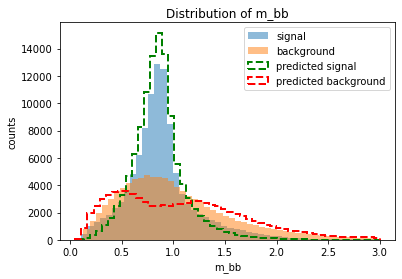

In [19]:
# plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, "m_bb")

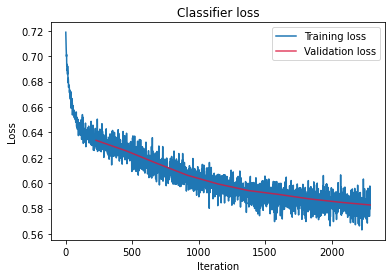

In [20]:
# Plot loss
plotLoss(trainSummary, valSummary)

In [21]:
!kubectl get pods

NAME                                         READY   STATUS    RESTARTS   AGE
jupyter-marchisi01-84d4039b941ca18e-exec-1   1/1     Running   0          4m35s
jupyter-marchisi01-84d4039b941ca18e-exec-2   1/1     Running   0          4m35s
jupyter-marchisi01-84d4039b941ca18e-exec-3   1/1     Running   0          4m35s
jupyter-marchisi01-84d4039b941ca18e-exec-4   1/1     Running   0          4m35s
jupyter-marchisi01-84d4039b941ca18e-exec-5   1/1     Running   0          4m35s


In [22]:
# Once done, stop spark
spark.stop()

## Exercise

- play with the batch size, how does it affect performances/training time?
- play with the model parameters and see if you can improve the performances
- how is training time affected by the number of parameters?
- try to make scaling tests, i.e. training time vs number of workers 
- compare the performances to the models from the previous days (MCP and Keras)